In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos.supervised import SupervisedEngine

from common.models import resnet, deeplab
from common import metrics
from common.models.modutils import load_model


c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Zumo\anaconda3\envs\torch-gpu\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Hyperparameters

In [3]:
log_dir = "./final/baseline"

horizon = 1024
stride = 512

batch_size = 16

num_epochs = 10

learning_rate = 1e-4

weight_decay = 1e-1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Datasets

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


In [6]:
train_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride),
    batch_size,
    shuffle=False,
)


# Model

In [7]:
model = deeplab.DeepLabNet(
    resnet.ResNetFeatures(
        resnet.Bottleneck,
        resnet.RESNET50_LAYERS,
        num_features=data.NUM_FEATURES,
        return_layers=[resnet.LAYER_1, resnet.LAYER_4],
        replace_stride_with_dilation=[False, True, True],
    ),
    backbone_channels=[256, 2048],
    out_feats=1,
)

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, num_epochs)
engine_supervised = SupervisedEngine(
    model, device, optimizer=optim, lr_scheduler=lr_sched
)


# Training

In [8]:
with SummaryWriter(log_dir + "/logs") as writer:
    training_loop(
        engine=engine_supervised,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/models",
    )


Epoch 0 - train_loss=0.159 - test_loss=0.159 - cost=0.150 - threshold=-1.062 - lr=1.00e-04


Epoch 1 - train_loss=0.144 - test_loss=0.144 - cost=0.129 - threshold=-1.905 - lr=9.76e-05


Epoch 2 - train_loss=0.109 - test_loss=0.139 - cost=0.130 - threshold=-1.863 - lr=9.05e-05


Epoch 3 - train_loss=0.125 - test_loss=0.127 - cost=0.110 - threshold=-1.989 - lr=7.94e-05


Epoch 4 - train_loss=0.081 - test_loss=0.118 - cost=0.105 - threshold=-2.149 - lr=6.55e-05


Epoch 5 - train_loss=0.059 - test_loss=0.121 - cost=0.104 - threshold=-1.795 - lr=5.00e-05


Epoch 6 - train_loss=0.083 - test_loss=0.118 - cost=0.095 - threshold=-2.646 - lr=3.45e-05


Epoch 7 - train_loss=0.060 - test_loss=0.123 - cost=0.095 - threshold=-2.163 - lr=2.06e-05


Epoch 8 - train_loss=0.082 - test_loss=0.116 - cost=0.088 - threshold=-2.497 - lr=9.55e-06


Epoch 9 - train_loss=0.077 - test_loss=0.118 - cost=0.090 - threshold=-2.162 - lr=2.45e-06


# Evaluating

In [9]:
load_model(model, log_dir + "/models/model_9.pth", device);

In [10]:
# Cost model
cmodel = metrics.default_cmodel()


In [11]:
scores, labels = get_predictions(engine_supervised.predict, test_loader)


100%|██████████| 41/41 [00:08<00:00,  4.93it/s]


In [12]:
cmodel.fit(scores, labels).optimize()


(-2.1622798919677724, 0.08996299)

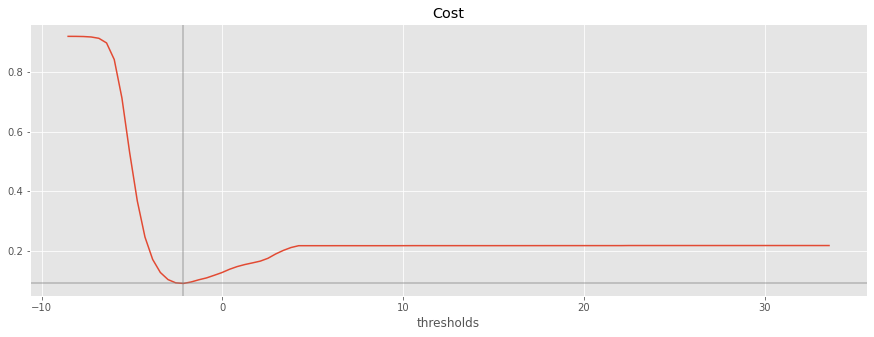

In [13]:
metrics.plot_cost(cmodel)


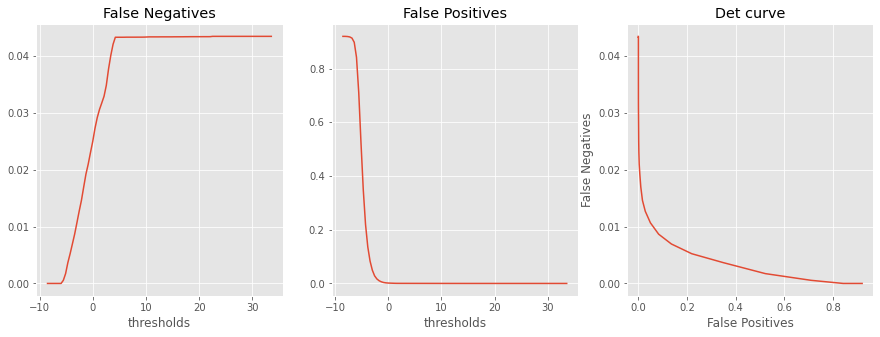

In [14]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


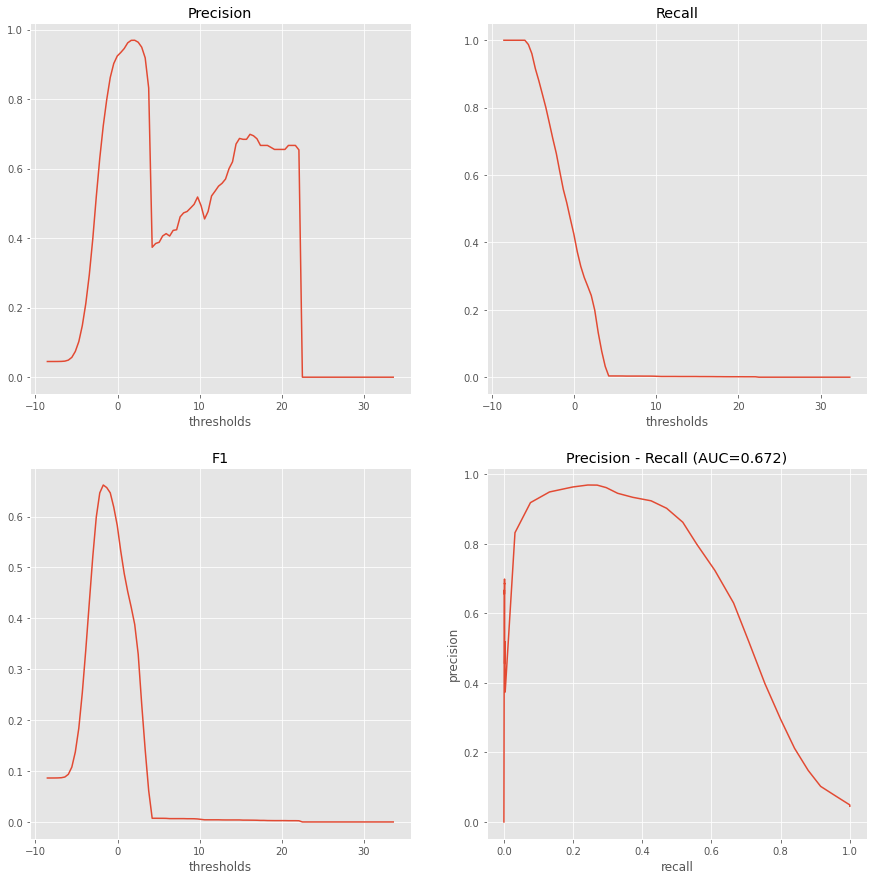

In [15]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)
